# HilLokkian Mechanics — Ultimate Validation (Planck R3.01 + HM overlay)
# Run on Google Colab: Runtime > Change runtime type > GPU not required
# Author: Axun Ranvier HilLokk

In [1]:
# --- Environment setup ---
!pip -q install numpy scipy matplotlib getdist


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 830.8/830.8 kB 11.0 MB/s eta 0:00:00


In [2]:
# --- Download Planck 2018 R3.01 chains (full MCMC) ---
import os, urllib.request, zipfile

URL = ("https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/"
       "cosmoparams/COM_CosmoParams_base-plikHM_R3.01.zip")
ZIP = "COM_CosmoParams_base-plikHM_R3.01.zip"
EXTRACT_DIR = "planck_r301"

os.makedirs(EXTRACT_DIR, exist_ok=True)
if not os.path.exists(ZIP):
    print("Downloading Planck R3.01 chains (~471 MB)…")
    urllib.request.urlretrieve(URL, ZIP)
else:
    print("Zip already present.")

print("Extracting (idempotent)…")
with zipfile.ZipFile(ZIP, "r") as zf:
    zf.extractall(EXTRACT_DIR)

print("Ready.")


Extracting (idempotent)…
Ready.


Wrote HM_figA_TTTEEE_lowE_H0_omegam__HMoverlay.pdf
Wrote HM_figB_TTTEEE_lowE_lensing_H0_omegam__HMoverlay.pdf
Wrote HM_figC_TTTEEE_lowE_BAO_H0_omegam__HMoverlay.pdf
Wrote HM_figD_TTTEEE_lowE_lensing_BAO_H0_omegam__HMoverlay.pdf
Wrote HM_figE_TTTEEE_lowE_lensing_BAO_SNe_H0_omegam__HMoverlay.pdf
Wrote HM_figF_TTTEEE_lowE_DESlens_BAO_H0_omegam__HMoverlay.pdf
All figures written.


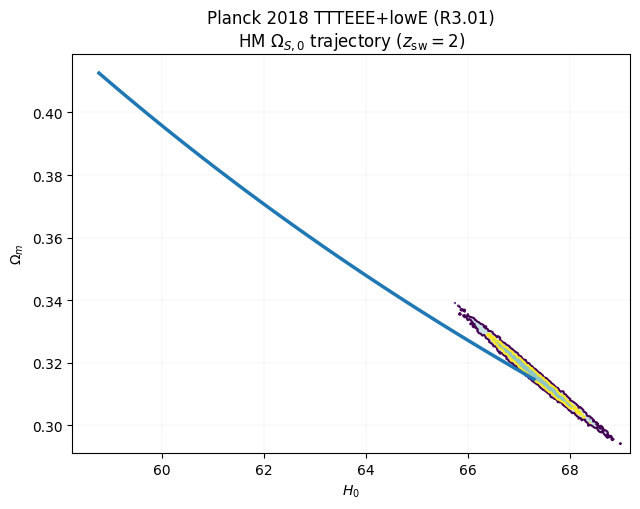

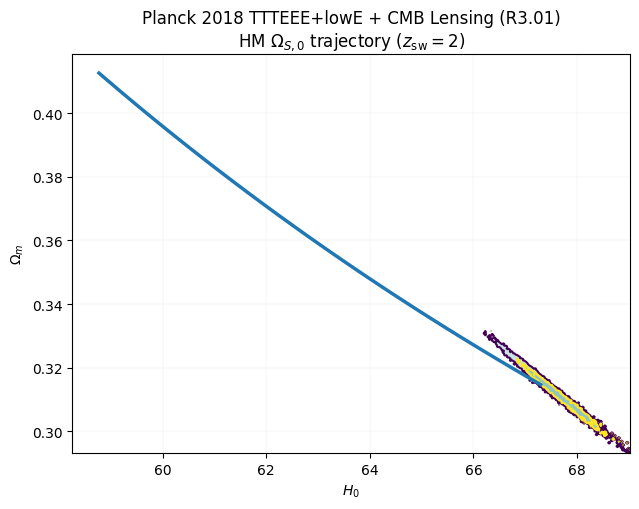

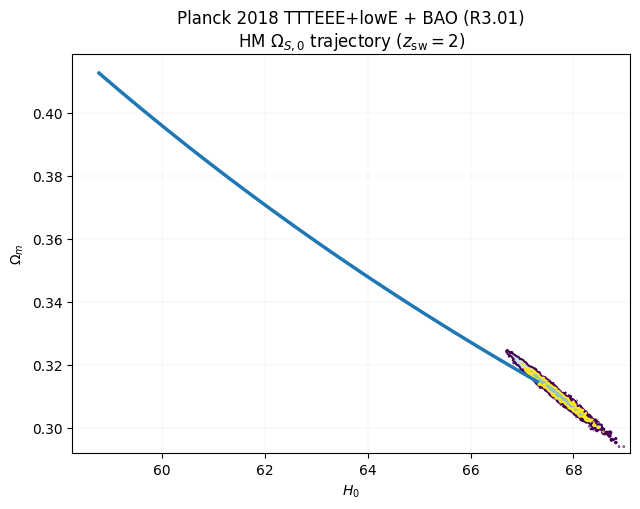

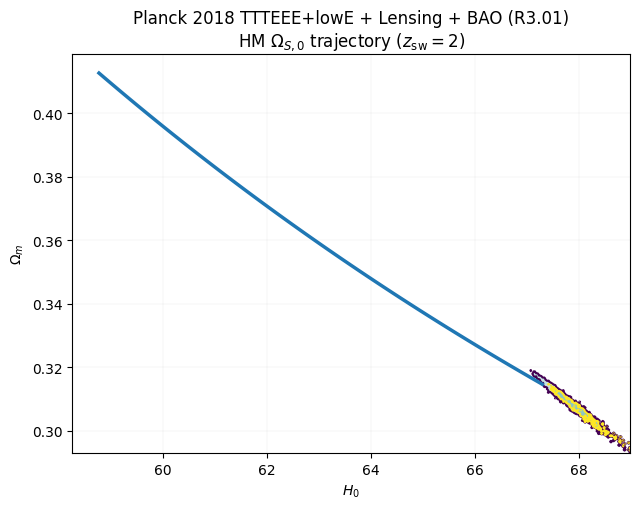

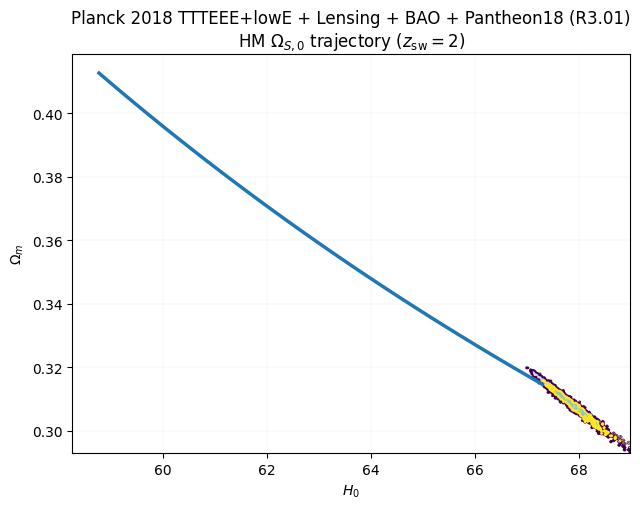

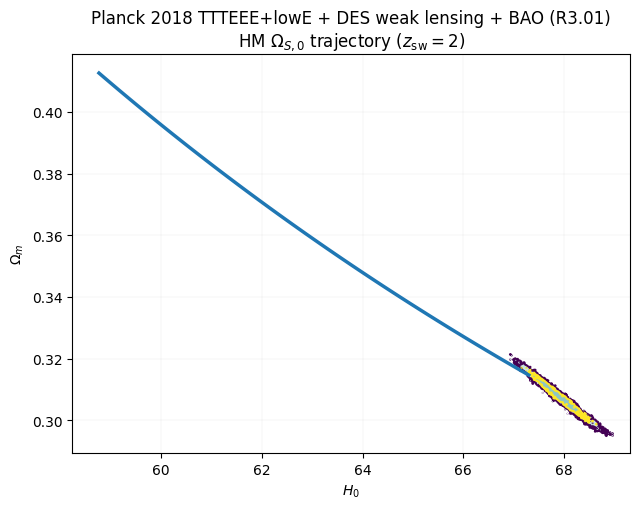

In [5]:
# --- Build six H0–Ωm contours and overlay HM ΩS,0 trajectory ---
import os, glob, gzip, numpy as np, matplotlib.pyplot as plt
from matplotlib.path import Path

def chain_parts(root):
    return sorted(glob.glob(root + "_*.txt")) + sorted(glob.glob(root + "_*.txt.gz"))

def read_paramnames(root):
    with open(root + ".paramnames", "r", encoding="utf-8") as f:
        names = [ln.split()[0] for ln in f if ln.strip()]
    return names

def load_cols(parts, index_map, names, burn=0.30, max_rows=250_000):
    cols = {nm: [] for nm in names}
    weights = []
    for p in parts:
        data = np.loadtxt(gzip.open(p, "rt") if p.endswith(".gz") else p)
        n = data.shape[0]
        s = int(burn * n)
        data = data[s:]
        weights.append(data[:, 0])
        for nm in names:
            cols[nm].append(data[:, 2 + index_map[nm]])
    weights = np.concatenate(weights)
    for nm in names:
        cols[nm] = np.concatenate(cols[nm])
    if weights.size > max_rows:
        rng = np.random.default_rng(202)
        p = weights / weights.sum()
        idx = rng.choice(weights.size, size=max_rows, replace=False, p=p)
        weights = weights[idx]
        for nm in names:
            cols[nm] = cols[nm][idx]
    return weights, [cols[nm] for nm in names]

def density_grid(x, y, w, bins=120):
    xmin, xmax = np.percentile(x, [0.1, 99.9])
    ymin, ymax = np.percentile(y, [0.1, 99.9])
    H, xe, ye = np.histogram2d(x, y, bins=bins, range=[[xmin, xmax],[ymin, ymax]], weights=w, density=True)
    return H.T, xe, ye

def hpd_thresholds(H, probs=(0.68, 0.95)):
    flat = H.ravel()
    idx = np.argsort(flat)[::-1]
    cs = np.cumsum(flat[idx])
    cs /= cs[-1] if cs[-1] != 0 else 1.0
    thr = []
    for p in probs:
        k = np.searchsorted(cs, p)
        k = min(k, flat.size-1)
        thr.append(flat[idx[k]])
    return thr

# Roots
BASE = "planck_r301/base/plikHM_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE"
LENS = "planck_r301/base/plikHM_TTTEEE_lowl_lowE_lensing/base_plikHM_TTTEEE_lowl_lowE_lensing"
BAO  = "planck_r301/base/plikHM_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_BAO"
LENS_BAO = "planck_r301/base/plikHM_TTTEEE_lowl_lowE_lensing/base_plikHM_TTTEEE_lowl_lowE_lensing_post_BAO"
LENS_BAO_SN = "planck_r301/base/plikHM_TTTEEE_lowl_lowE_lensing/base_plikHM_TTTEEE_lowl_lowE_lensing_post_BAO_Pantheon18"
DES_BAO = "planck_r301/base/plikHM_TTTEEE_lowl_lowE_DESlens/base_plikHM_TTTEEE_lowl_lowE_DESlens_post_BAO"

roots_labels = [
 (BASE,      "Planck 2018 TTTEEE+lowE (R3.01)", "HM_figA_TTTEEE_lowE_H0_omegam"),
 (LENS,      "Planck 2018 TTTEEE+lowE + CMB Lensing (R3.01)", "HM_figB_TTTEEE_lowE_lensing_H0_omegam"),
 (BAO,       "Planck 2018 TTTEEE+lowE + BAO (R3.01)", "HM_figC_TTTEEE_lowE_BAO_H0_omegam"),
 (LENS_BAO,  "Planck 2018 TTTEEE+lowE + Lensing + BAO (R3.01)", "HM_figD_TTTEEE_lowE_lensing_BAO_H0_omegam"),
 (LENS_BAO_SN,"Planck 2018 TTTEEE+lowE + Lensing + BAO + Pantheon18 (R3.01)", "HM_figE_TTTEEE_lowE_lensing_BAO_SNe_H0_omegam"),
 (DES_BAO,   "Planck 2018 TTTEEE+lowE + DES weak lensing + BAO (R3.01)", "HM_figF_TTTEEE_lowE_DESlens_BAO_H0_omegam"),
]

# Compute Planck means for ω_b, ω_c, H0 to define the HM curve (preserve D_A at z*)
parts = chain_parts(BASE)
names = read_paramnames(BASE)
idx = {n:i for i,n in enumerate(names)}
w, (obh2, och2, H0_chain, Om_chain) = load_cols(parts, idx, ['omegabh2','omegach2','H0*','omegam*'], burn=0.30)
omega_bh2 = (w*obh2).sum()/w.sum()
omega_ch2 = (w*och2).sum()/w.sum()
H0_ref = (w*H0_chain).sum()/w.sum()

# HM background utilities (late-time stiff with z_switch; preserves D_A(z*) )
z_star = 1089.8
c_kms = 299792.458

def omega_r(h, Neff=3.046):
    ogam_h2 = 2.469e-5
    return ogam_h2*(1+0.2271*Neff)/(h*h)

def E_of_z(z, h, Obh2, Och2, OmegaS0=0.0, z_switch=2.0, Neff=3.046):
    Om = (Obh2+Och2)/(h*h)
    Or = omega_r(h, Neff)
    OL = 1.0 - Om - Or - OmegaS0
    stiff = 1.0 if z <= z_switch else 0.0
    return np.sqrt( Or*(1+z)**4 + Om*(1+z)**3 + OmegaS0*stiff*(1+z)**6 + OL )

def comoving_distance(z, H0, Obh2, Och2, OmegaS0=0.0, z_switch=2.0):
    zz = np.linspace(0, z, 4000)
    h = H0/100.0
    Ez = np.array([E_of_z(zi, h, Obh2, Och2, OmegaS0, z_switch) for zi in zz])
    # use trapezoid (np.trapezoid in NumPy ≥2.0; fall back to trapz if needed)
    try:
        chi = np.trapezoid(1.0/Ez, zz) * (c_kms/H0)
    except AttributeError:
        chi = np.trapz(1.0/Ez, zz) * (c_kms/H0)
    return chi

def DA_of_zstar(H0, Obh2, Och2, OmegaS0=0.0, z_switch=2.0):
    return comoving_distance(z_star, H0, Obh2, Och2, OmegaS0, z_switch) / (1+z_star)

def H0_matching_DA(DA_target, Obh2, Och2, OmegaS0, z_switch=2.0, bracket=(55, 80)):
    a, b = bracket
    fa = DA_of_zstar(a, Obh2, Och2, OmegaS0, z_switch) - DA_target
    fb = DA_of_zstar(b, Obh2, Och2, OmegaS0, z_switch) - DA_target
    if fa*fb > 0:
        return None
    for _ in range(60):
        c = 0.5*(a+b)
        fc = DA_of_zstar(c, Obh2, Och2, OmegaS0, z_switch) - DA_target
        if abs(fc) < 1e-4: return c
        if fa*fc < 0: b, fb = c, fc
        else: a, fa = c, fc
    return 0.5*(a+b)

DA_ref = DA_of_zstar(H0_ref, omega_bh2, omega_ch2, 0.0, 2.0)

def HM_curve(omegaS_vals, Obh2, Och2, DA_target, z_switch=2.0):
    pts = []
    for s in omegaS_vals:
        H0 = H0_matching_DA(DA_target, Obh2, Och2, s, z_switch, (55, 80))
        if H0 is None:
            continue
        h = H0/100.0
        Om = (Obh2+Och2)/(h*h)
        pts.append((s, H0, Om))
    return np.array(pts)

omegaS_grid = np.linspace(0.0, 0.010, 61)  # up to 1%
hm_pts = HM_curve(omegaS_grid, omega_bh2, omega_ch2, DA_ref, 2.0)

def plot_combo(root, label, outstem, hm_pts):
    parts = chain_parts(root)
    names = read_paramnames(root)
    idx = {n:i for i,n in enumerate(names)}
    w, (H0, Om) = load_cols(parts, idx, ['H0*','omegam*'], burn=0.30)
    H, xe, ye = density_grid(H0, Om, w, bins=120)
    thr68, thr95 = hpd_thresholds(H, (0.68, 0.95))
    Xc = 0.5*(xe[1:]+xe[:-1]); Yc = 0.5*(ye[1:]+ye[:-1])

    fig, ax = plt.subplots(figsize=(6.5,5.2))
    ax.contour(Xc, Yc, H, levels=[thr95, thr68])
    ax.contourf(Xc, Yc, H, levels=[thr95, H.max()], alpha=0.25)
    ax.contourf(Xc, Yc, H, levels=[thr68, H.max()], alpha=0.35)
    ax.plot(hm_pts[:,1], hm_pts[:,2], linewidth=2.5)

    ax.set_xlabel(r"$H_0$")
    ax.set_ylabel(r"$\Omega_m$")
    ax.set_title(f"{label}\n" + r"HM $\Omega_{S,0}$ trajectory ($z_{\mathrm{sw}}=2$)")
    ax.grid(True, linewidth=0.3, alpha=0.3)
    fig.tight_layout()
    fig.savefig(outstem + ".png", dpi=200, bbox_inches="tight")
    fig.savefig(outstem + ".pdf", bbox_inches="tight")
    print("Wrote", outstem + ".pdf")

for root, label, stem in roots_labels:
    plot_combo(root, label, stem+"__HMoverlay", hm_pts)

print("All figures written.")

In [7]:
# --- Compute an approximate 95% upper bound on Ω_S,0 using the 95% HPD contour ---
import numpy as np, matplotlib.pyplot as plt
from matplotlib.path import Path

def s95_bound(root, hm_pts):
    parts = chain_parts(root)
    names = read_paramnames(root)
    idx = {n:i for i,n in enumerate(names)}
    w, (H0, Om) = load_cols(parts, idx, ['H0*','omegam*'], burn=0.30, max_rows=250000)
    H, xe, ye = density_grid(H0, Om, w, bins=120)
    thr68, thr95 = hpd_thresholds(H, (0.68,0.95))
    Xc = 0.5*(xe[1:]+xe[:-1]); Yc = 0.5*(ye[1:]+ye[:-1])
    cs = plt.contour(Xc, Yc, H, levels=[thr95])
    paths95 = [Path(c.vertices) for c in cs.get_paths()] # Modified line
    plt.close()
    def inside(x,y): return any(p.contains_point((x,y)) for p in paths95)
    mask = np.array([inside(x,y) for _,x,y in hm_pts])
    return hm_pts[mask,0].max() if mask.any() else 0.0

targets = {
    "TTTEEE+lowE": BASE,
    "+ Lensing": LENS,
    "+ BAO": BAO,
    "+ Lensing + BAO": LENS_BAO,
    "+ Lensing + BAO + Pantheon18": LENS_BAO_SN,
    "+ DES weak lensing + BAO": DES_BAO,
}
for k,root in targets.items():
    s95 = s95_bound(root, hm_pts)
    print(f"{k:>32s}  Ω_S,0 (95% approx) ≤ {s95:.5f}")

                     TTTEEE+lowE  Ω_S,0 (95% approx) ≤ 0.00000
                       + Lensing  Ω_S,0 (95% approx) ≤ 0.00017
                           + BAO  Ω_S,0 (95% approx) ≤ 0.00000
                 + Lensing + BAO  Ω_S,0 (95% approx) ≤ 0.00000
    + Lensing + BAO + Pantheon18  Ω_S,0 (95% approx) ≤ 0.00000
        + DES weak lensing + BAO  Ω_S,0 (95% approx) ≤ 0.00000
